# Deep Learning 2
We will provide a detailed explanation based on the time series prediction program introduced on the second lecture.

1 Loss: 127.90886529236083
2 Loss: 16.8267027362232
3 Loss: 6.821705942985359
4 Loss: 5.180820410228838
5 Loss: 4.8546402589625615
6 Loss: 4.595477696911544
7 Loss: 4.279621730042491
8 Loss: 4.135038658312172
9 Loss: 4.255960167118698
10 Loss: 4.11698785196444
11 Loss: 4.106634519377332
12 Loss: 4.094013721367736
13 Loss: 4.056656055152416
14 Loss: 3.9008290978018074
15 Loss: 3.98053980808539
16 Loss: 3.796200296705126
17 Loss: 3.928483605906842
18 Loss: 3.8754645866122406
19 Loss: 3.8304544724761302
20 Loss: 3.94565830840047
21 Loss: 3.8359980659832242
22 Loss: 3.8155857628792713
23 Loss: 3.779790304363913
24 Loss: 3.73531103067717
25 Loss: 3.6718992864606297
26 Loss: 3.7218190738160137
27 Loss: 3.7243308872577683
28 Loss: 3.668504464232428
29 Loss: 3.7199047091802595
30 Loss: 3.6907900172244212
31 Loss: 3.7052221354808967
32 Loss: 3.515239839032767
33 Loss: 3.60467418878796
34 Loss: 3.521190907924798
35 Loss: 3.3694035840594463
36 Loss: 3.3335851208799205
37 Loss: 3.358267200814121
3

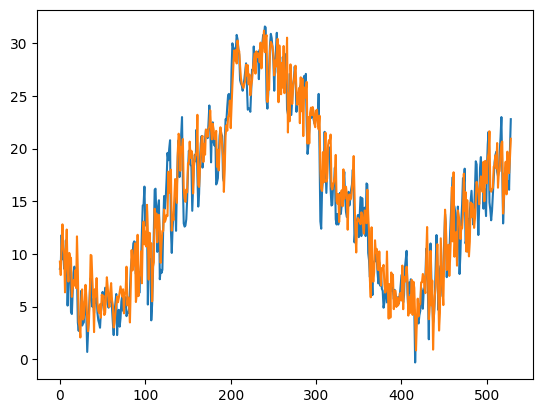

In [28]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Read Japanese weather data
df = pd.read_csv('./weather.csv', parse_dates=True, index_col=0)
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=False)

# Make training data and test data
# Predict the average temperature in the next day using the previous 20 days data
window_size = 20
n_dim = df_train.shape[1]
n_train = len(df_train) - window_size
n_test = len(df_test) - window_size

train = np.zeros((n_train, window_size, n_dim))
train_label = np.zeros((n_train, n_dim))
for i in range(n_train):
    train[i] = df_train[i:i+window_size]
    train_label[i] = df_train[i+window_size:i+window_size+1]
train_label = train_label[:,2]

dataset = torch.utils.data.TensorDataset(torch.tensor(train, dtype=torch.float),  torch.tensor(train_label, dtype=torch.float))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

test = np.zeros((n_test, window_size, n_dim))
test_label = np.zeros((n_test, n_dim))
for i in range(n_test):
    test[i] = df_test[i:i+window_size]
    test_label[i] = df_test[i+window_size:i+window_size+1]
test = torch.tensor(test, dtype=torch.float)
test_label = test_label[:,2]

# Define the neural network model with LSTM
class TSLSTM(torch.nn.Module):
    def __init__(self, feature_size, hidden_dim, n_layers=1):
        super(TSLSTM, self).__init__()
        
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_output = 1
        
        self.lstm = torch.nn.LSTM(feature_size, hidden_dim, n_layers, batch_first=True)
        self.l = torch.nn.Linear(hidden_dim, self.n_output)
        
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        
        output, (hn, cn) = self.lstm(x, (h0, c0))
        y = self.l(hn.squeeze(0))

        return y

feature_size = 6
n_hidden = 64
n_layers = 1
model = TSLSTM(feature_size, n_hidden, n_layers)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100
for epoch in range(epochs):
    total_loss = 0.0
    for i, (x, l) in enumerate(train_loader):
        optimizer.zero_grad()
        
        y = model(x)
        loss = criterion(y.reshape(-1), l)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    print('{0} Loss: {1}'.format(epoch+1, total_loss/i))

pred = model(test).detach().numpy()

plt.plot(range(n_test), test_label)
plt.plot(range(n_test), pred)

## Elman Network
Considering all the past inputs, we have to introduce a new mechanism into a neural network.
One solution is recurrent mechanism, which uses the previous hidden state repeatedly because the hidden state means the abstractive infromation including all the past inputs.
The architecture is the follo
<img src='./Elman.jpg' width='300'>
This architecture is called Elman network and it is so simple architecture to realize a recurrent neural network.

The Elman network includes the weights between the input layer and the hidden layer, the weights between the hidden layer and the output layer, and the wieghts for the feedback loop.
If we neglect the feedback loop, the network is a simple fully-connected multiple layer neural network.

When we use the Elman network after training, all the weights are stable.
Especially, the feedback weight mean that how much the network emphasize the past information.
For example, when the weight is under 1, the past information is not emphasized comparing with the new input.
It means that the neural network tends to forget the past information rapidly.
On the other hand, when the weight is over 1, the past information is emphasized comparing with the new input.
It means that the neural network tends to predit the target with only the past information.
So, it is important to determine an appropriate feedback weight but it is difficult to control the feedback weight learning because the learning is executed with a gradient of the neural network.



In [34]:
import torch
import numpy as np

class Elman(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Elman, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.l1 = torch.nn.Linear(input_size, hidden_size)
        self.l2 = torch.nn.Linear(hidden_size, output_size)
        self.feedback = torch.nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x):
        prev_h = torch.zeros(x.shape[0], self.hidden_size)
        for i in range(x.shape[1]):
            h = self.l1(x[:, i, :])
            o = self.l2(h + self.feedback(prev_h))
            prev_h = h
        
        return o

model = Elman(6, 64, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    toal_loss = 0.0
    for i, (x, l) in enumerate(train_loader):
        optimizer.zero_grad()

        y = model(x)
        loss = criterion(y, l)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(epoch+1, 'Loss:', total_loss)

1 Loss: 22239.855977337807
2 Loss: 41360.40575341508
3 Loss: 60751.94227198884
4 Loss: 79798.19486836717
5 Loss: 98638.27369169518
6 Loss: 117407.66807226464
7 Loss: 136416.8784113936
8 Loss: 154723.03825626895
9 Loss: 173726.03958068416
10 Loss: 192331.70899568126
11 Loss: 210753.97254024073
12 Loss: 229173.93009696528
13 Loss: 247798.04041514918
14 Loss: 266307.3651305251
15 Loss: 285026.05033026263
16 Loss: 303587.59889016673
17 Loss: 322164.2826679759
18 Loss: 340633.93349860236
19 Loss: 359430.2166492753
20 Loss: 377847.50233028457
21 Loss: 396251.2042517476
22 Loss: 414329.9971155934
23 Loss: 432757.95345328376
24 Loss: 451215.9112036042
25 Loss: 469872.7965926938
26 Loss: 488420.9238321595
27 Loss: 507112.1980640702
28 Loss: 525695.3517300896
29 Loss: 544049.259630423
30 Loss: 562159.9977545552
31 Loss: 580721.4614786915
32 Loss: 598711.9191388898
33 Loss: 617073.3545174412
34 Loss: 635058.4851548485
35 Loss: 653114.8597838692
36 Loss: 671405.6273615174
37 Loss: 689630.705905418

The neural network training is very sensitive to the initial weigth settings.
When we do not set the initial weights carefully, the neural network often is not trained appropriately.


## LSTM (Long Short-Term Memory)
Now we discuss a simple recurrent neural network, Elman network.
The main problem of Elman network is how to learn the feedback weight.
When the feedback weight is over 1 or under 1, the netwrok does not work well.

One solution is that the feedback weight is equal to 1 because the past information keeps in the neural network.
However, using this strategy, we cannot manage the past information at all.
So, LSTM introduces additional mechanism, a forget gate, an input gate, and an output gate, to manage the past infromation.

First, the forget gete cuts off the feedback connection and the neural network forget the past information.
<img src='LSTM1.jpg' width=300>
By controlling the forget gate, we can manage the past information.
Of course, the control of this gate is also done based on the input data.

We execute further improvement of the recurrent neural network.
The forget gate now allows us to decide whether to carry over past history.
To further enhance it, if we can skip certain inputs, it becomes possible to process only specific characteristic inputs.
We introduce the input gate to judge whether an input is accepted or not.
<img src='LSTM2.jpg' width=300>

The final improvement is adding the output gate.
If a network performs multiple feature extractions, it would be beneficial to have the option for certain feature extraction parts not to produce an output.
This is because if it doesn't output, that part won't contribute to the prediction and error calculation, no learning will occur. 
This functionality is particularly useful when learning is done for each feature.
<img src='LSTM3.jpg' width=300>


This is the architecture of LSTM, and since all gates are controlled by the input data, the processing becomes data-driven.

## Bidirectional Recurrent Neural Network
When expanding on the information to consider, it's possible to use not only the preceding information but also the surrounding context.
To utilize the surrounding information, two LSTM units are combined, where the processing order of one is the reverse of the other.
We call the pair of LSTM a bidirectional LSTM.
The bidirectional LSTM is a commonly used method in natural language processing.


# Assignment


Please predict how the prediction accuracy will change by modifying the window size, stacking multiple LSTM layers, and so on.